# RPGRIP1 and Associated Syndrome

<!-- Provide a brief overview of the syndrome and its genetic basis. Replace [Gene Name] and [Syndrome Name] with the specific gene and syndrome you are studying. -->

[[Syndrome Name]](link_to_syndrome) is an [type of disease, e.g. autosomal dominant] disease characterized by [describe main features of the syndrome]. The syndrome is caused by pathogenic variants in the [[GeneName]](link_to_gene) gene.

<!-- Summarize key findings from previous studies on genotype-phenotype correlations in the syndrome. -->

One/Two/Several previous publications have reported candidate genotype-phenotype correlations in [Syndrome Name].

<!-- Cite specific studies and their findings. Replace with relevant studies and findings for the specific gene and syndrome. -->

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) stated that:

> [Quote relevant finding from the study]

[Author et al. (Year)](link_to_study) report:

> [Quote relevant finding from the study]

<!-- TODO: Add instructions for finding more comprehensive citations and explain the next steps in your analysis. -->

TODO -- find a more comprehensive collection of citations for [GeneName]. At the end of the introduction for a gene, we would write something like this:

> Example: Therefore, we tested missense vs other variants (inspection of the distribution of variants showed that the other variant categories in our dataset are [list other variant categories], all of which we deemed to be null variants for the purposes of this analysis). We also tested the two most common missense variants ([DETAILS]) for correlations.

In [1]:
import gpsea
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.3.1.dev0


In [2]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
cohort_name = "RPGRIP1"
with phenopacket_registry.open_phenopacket_store('0.1.18') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))
print(f"Imported {len(phenopackets)} phenopackets from cohort {cohort_name}")

Imported 229 phenopackets from cohort RPGRIP1


In [3]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

Patients Created: 100%|██████████| 229/229 [05:05<00:00,  1.33s/it]


In [4]:
validation.summarize()  

Validated under none policy
No errors or warnings were found


In [5]:
RPGRIP1_MANE_transcript = 'NM_020366.4'
RPGRIP1_protein_id = 'NP_065099.3' # X-linked retinitis pigmentosa GTPase regulator-interacting protein 1 isoform 1

In [7]:
from gpsea.view import CohortViewable
cv = CohortViewable(hpo=hpo)
report = cv.process(cohort=cohort, transcript_id=RPGRIP1_MANE_transcript)
display(HTML(report))

HPO Term,ID,Seen in n individuals
Very low visual acuity,HP:0032122,89
Abnormal electroretinogram,HP:0000512,28
Eye poking,HP:0001483,28
Moderately reduced visual acuity,HP:0030515,24
Global developmental delay,HP:0001263,12
Moderate hypermetropia,HP:0031729,12
Constriction of peripheral visual field,HP:0001133,10
High hypermetropia,HP:0008499,9
Severely reduced visual acuity,HP:0001141,6
High myopia,HP:0011003,4


In [8]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(RPGRIP1_MANE_transcript)
protein_meta = pms.annotate(RPGRIP1_protein_id)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_80249/3621751448.py:4: DeprecationWarning: Use `configure_default_protein_metadata_service` instead
  pms = configure_protein_metadata_service()


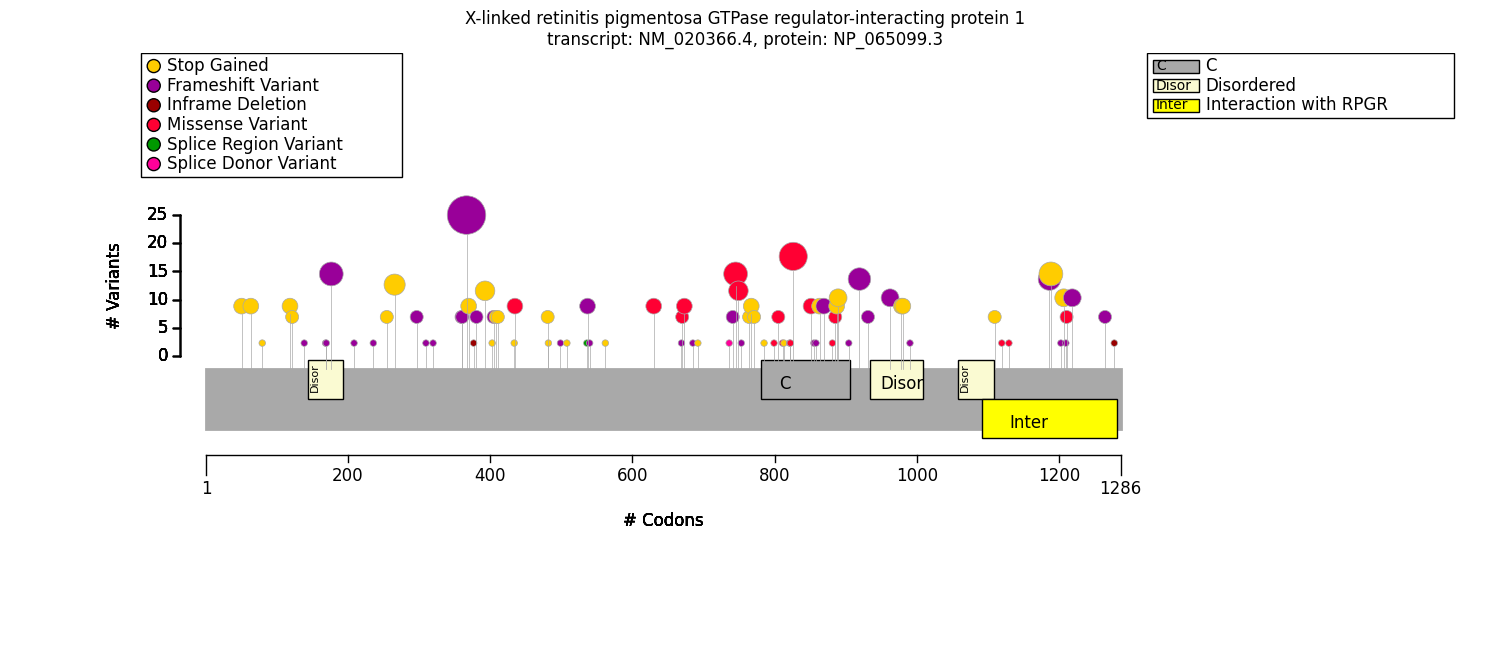

In [9]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [11]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, groups_predicate,VariantPredicate

vp = VariantPredicates.variant_key("14_21312457_21312458_GA_G") 

gt_predicate = groups_predicate(
    predicates=(
        vp,
        ~vp,
    ),
    group_names=('Special mutation', 'Others'),
)
gt_predicate.display_question()

'Genotype group: Special mutation, Others'

In [22]:
from gpsea.analysis.predicate.genotype import ModeOfInheritancePredicate

gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(
    variant_predicate=vp,
)


from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=2,
)
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.mtc_filter import UseAllTermsMtcFilter
use_all = UseAllTermsMtcFilter()
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.1)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest
count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

from gpsea.model import FeatureType
from gpsea.analysis.predicate import PatientCategories


missense_effects = (VariantEffect.MISSENSE_VARIANT)
missense_predicate = VariantPredicates.all(VariantPredicates.variant_effect(eff) for eff in missense_effects)


result = missense_predicate.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=missense_predicate,
)

TypeError: 'VariantEffect' object is not iterable